In [1]:
%matplotlib inline
import time
import matplotlib as mpl
import matplotlib.pylab as plt
from matplotlib.animation import FuncAnimation
import scipy.optimize as scop


import numpy as np
import random
import seaborn as sns

sns.set_style("dark")


In [2]:
class Dice:
    def __init__(self, d_max=6, d_min=1, pre_trigger=False):
        self.d_max = d_max
        self.d_min = d_min
        if pre_trigger:
            self.value = random.randint(self.d_min, self.d_max)
        else:
            self.value = random.randint(self.d_min, self.d_max-1)
        if self.value == self.d_max:
            self.done = True
        else:
            self.done = False        
        
    def roll(self):
        if self.done:
            return False
        else:
            self.value = random.randint(self.d_min, self.d_max)
            if self.value == self.d_max:
                self.done = True
                return True
            else:
                self.done = False
                return False
        
  

class DiceArray:
    def __init__(self, N=10, d_max=6, d_min=1, pre_trigger=False):
        self.N = N
        self.array = np.array([Dice(d_max=d_max, d_min=d_min, pre_trigger=pre_trigger) for i in range(N*N)])
        
    def values(self):
        return np.array([d.value for d in self.array])
    
    def done(self):
        return np.array([d.done for d in self.array])
    
    def roll(self):
        c = 0
        todo = self.array[~self.done()]
        for d in todo:
            c += d.roll()
        return c
    
    def value_grid(self):
        grid = np.reshape(self.values(), (self.N, self.N))
        return grid 
    
    def done_grid(self):
        grid = np.reshape(self.done(), (self.N, self.N))
        return grid 
    
    def count_untriggered(self):
        done = self.done()
        return len(done) - sum(done)
    

In [3]:
def roll_all(dice_array):
    timesteps = []
    activities = []
    i = 0
    while dice_array.count_untriggered() > 0:
        i += 1
        c = dice_array.roll()
        timesteps.append(i)
        activities.append(c)
    return np.array(timesteps), np.array(activities)

def monoExp(x, m, t):
    return m * np.exp(-t * x)

def plot_activity(timesteps, activities, trend_line=False, p0=10, p1=1):
    sns.set_style("whitegrid")
    f, ax = plt.subplots()
    ax.plot(timesteps, activities)
    ax.set_ylabel('Activity (counts per timestep)')
    ax.set_xlabel('Time Step')
    if trend_line:
        params, cv = scop.curve_fit(monoExp, timesteps, activities, (p0, p1))
        print(params)
        m, t = params
        ax.plot(timesteps, monoExp(timesteps, m, t), 'k:')
    plt.show()
    

def plot_rolls(dice_array, show_nums=True, fname='blah', start=0, end=-1, p0=10, p1=1):
    sns.set_style("white")
    fig = plt.figure(figsize=(6,8))
    ax1 = plt.subplot2grid((6, 3), (0, 0), colspan=3, rowspan=5)
    ax2 = plt.subplot2grid((6, 3), (5, 0), colspan=3)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_aspect('equal')#, adjustable='box')
    ax2.set_ylabel('Activity')
    ax2.set_xlabel('Time Step')
    cmap = mpl.colors.ListedColormap(['firebrick', 'moccasin'])

    timesteps = np.array([])
    activities = np.array([])
    
    done_grid = dice_array.done_grid()
    pcolors = ax1.pcolor(~done_grid, cmap=cmap)
    
    for timestep in range(9000):
        if end > 0:
            if timestep > end:
                break
        c = dice_array.roll()
        done_grid = dice_array.done_grid()
        if timestep < start:
            continue
        
        activities = np.append(activities, c)
        timesteps = np.append(timesteps, timestep-start)
        
        ax2.plot(timesteps, activities)
        
        ax1.pcolormesh(~done_grid, cmap=cmap)
            
        
        if show_nums:
            for t in ax1.texts:
                t.set_visible(False)
            value_grid = x.value_grid()
            shp = np.shape(value_grid)
            for xi in range(shp[0]):
                for yi in range(shp[1]):
                    ax1.text(yi+0.5, xi+0.5, value_grid[xi, yi], fontfamily='monospace')
                    
                    
        plt.savefig('{}\{}_ts{:04d}.jpg'.format(fname, fname, timestep), dpi=60)                
        if dice_array.count_untriggered() == 0:
            for _ in range(10):
                plt.savefig('{}\{}_ts{:04d}.jpg'.format(fname, fname,  timestep+1+_), dpi=60)
            break


    sns.set_style("whitegrid")
    f, ax3 = plt.subplots()
    ax3.plot(timesteps, activities)
    params, cv = scop.curve_fit(monoExp, timesteps, activities, (p0, p1))
    m, t = params
    ax3.plot(timesteps, monoExp(timesteps, m, t), 'k:')
    ax3.set_ylabel('Activity (counts per timestep)')
    ax3.set_xlabel('Time Step')
    plt.savefig('{}\{}_activity.jpg'.format(fname, fname, timestep+1+_))

In [4]:
N, d_max = 10, 6
x = DiceArray(N=N, d_max=d_max)
plot_rolls(x, show_nums=True, fname='{}x{}_{}'.format(N, N, d_max), p0=N*N/d_max, p1=1/N)

In [9]:
N, d_max = 30, 6
x = DiceArray(N=N, d_max=d_max)
plot_rolls(x, show_nums=False, fname='{}x{}_{}'.format(N, N, d_max), p0=N*N/d_max, p1=1/N)

In [4]:
N, d_max = 100, 6
x = DiceArray(N=N, d_max=d_max)
plot_rolls(x, show_nums=False, fname='{}x{}_{}'.format(N, N, d_max), p0=N*N/d_max, p1=1/N)

In [5]:
N, d_max = 300, 6
x = DiceArray(N=N, d_max=d_max)
plot_rolls(x, show_nums=False, fname='{}x{}_{}'.format(N, N, d_max), p0=N*N/d_max, p1=1/N)

In [6]:
N, d_max = 300, 12
x = DiceArray(N=N, d_max=d_max)
plot_rolls(x, show_nums=False, fname='{}x{}_{}'.format(N, N, d_max), p0=N*N/d_max, p1=1/N)

In [25]:
x06 = DiceArray(N=300, d_max=6)
ts06, acs06 = roll_all(x06)
ts06 = ts06-1

x12 = DiceArray(N=300, d_max=12)
ts12, acs12 = roll_all(x12)
ts12 = ts12-1


sns.set_style("whitegrid")
f, ax = plt.subplots()
ax.plot(ts06, acs06, label='6-sided')
#params, cv = scop.curve_fit(monoExp, ts06, acs06, (300.*300/6, 1/300.))
#m, t = params
#ax.plot(ts06, monoExp(ts06, m, t), 'k:')


ax.plot(ts12, acs12, label='12-sided')
#params, cv = scop.curve_fit(monoExp, ts12, acs12, (300.*300/12, 1/300.))
#m, t = params
#ax.plot(ts12, monoExp(ts12, m, t), 'k:')
ax.legend()
ax.set_ylabel('Activity (counts per timestep)')
ax.set_xlabel('Time Step')
ax.set_xlim([0,50])
ax.set_xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
plt.show()

In [22]:
sns.set_style("whitegrid")
ax.set_xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
plt.show()

In [23]:
sns.set_style("whitegrid")
ax.set_xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
plt.show()

In [24]:
plt.show()

0.13862943611198908


Text(0.5, 0, 'Time (hours)')

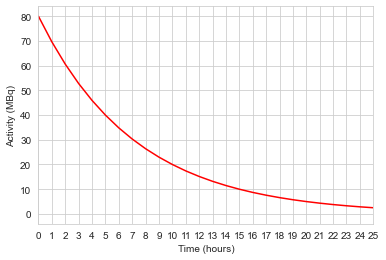

In [28]:
peakBq = 80
x = [0, 5, 10, 15, 20]
y = [1000, 500, 250, 125, 62.5]
params, cv = scop.curve_fit(monoExp, x, y, (1000, 0.014))
m, t = params
print(t)


x = np.arange(101)
sns.set_style("whitegrid")
f, ax = plt.subplots()
ax.plot(x, monoExp(x, peakBq, t), 'r')
ax.set_xticks(np.linspace(0, 25, 26))
ax.set_xlim([0,25])
ax.set_yticks(np.linspace(0, peakBq, 9))
ax.set_ylabel('Activity (MBq)')
ax.set_xlabel('Time (hours)')


[600.0, 375.0, 240.0, 142.5, 90.0, 49.5]
0.07863330539465913


Text(0.5, 0, 'Time (hours)')

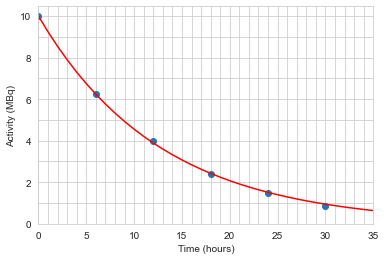

In [36]:
peakBq = 600
x_ = [0, 6, 12, 18, 24, 30]
y_ = [600, 375, 240, 145, 90, 50]
#y_ = [10.0, 6.25, 4.0, 2.375, 1.5, 0.825]
#y = [y*60. for y in y_]
print(y)
params, cv = scop.curve_fit(monoExp, x_, y_, (600, 0.079))
m, t = params
print(t)


x = np.arange(36)
sns.set_style("whitegrid")
f, ax = plt.subplots()
ax.plot(x, monoExp(x, peakBq, t), 'r')
ax.scatter(x_, y_)
ax.set_xticks(np.linspace(0, 35, 36))
ax.set_xticklabels(['0', '', '', '', '', '5',
                    '', '', '', '', '10',
                   '', '', '', '', '15',
                   '', '', '', '', '20',
                   '', '', '', '', '25',
                   '', '', '', '', '30',
                   '', '', '', '', '35',])
ax.set_xlim([0,35])
ax.set_yticks(np.linspace(0, peakBq, 11))
ax.set_yticklabels(['0', '', '2', '', '4', '', '6', '', '8', '', '10'])
ax.set_ylabel('Activity (MBq)')
ax.set_xlabel('Time (hours)')

0.016986881315464337


Text(0.5, 0, 'Time (minutes)')

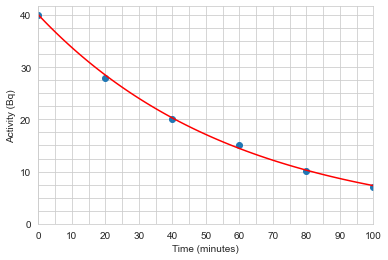

In [7]:
peakBq = 40
x_ = [0, 20, 40, 60, 80, 100]
y_ = [40.0, 28.0, 20.1, 15.0, 10.1, 7.1]
params, cv = scop.curve_fit(monoExp, x_, y_, (40, 0.079))
m, t = params
print(t)


x = np.arange(101)
sns.set_style("whitegrid")
f, ax = plt.subplots()
ax.plot(x, monoExp(x, peakBq, t), 'r')
ax.scatter(x_, y_)
ax.set_xticks(np.linspace(0, 100, 21))
ax.set_xticklabels(['0', '', '10', '', '20',
                    '', '30', '', '40',
                    '', '50', '', '60',
                    '', '70', '', '80',
                    '', '90', '', '100',])
ax.set_xlim([0,100])
ax.set_yticks(np.linspace(0, peakBq, 17))
ax.set_yticklabels(['0', '', '', '', '10',
                    '', '', '', '20',
                   '', '', '', '30',
                   '', '', '', '40',])
ax.set_ylabel('Activity (Bq)')
ax.set_xlabel('Time (minutes)')

Text(0.5, 0, 'Time (hours)')

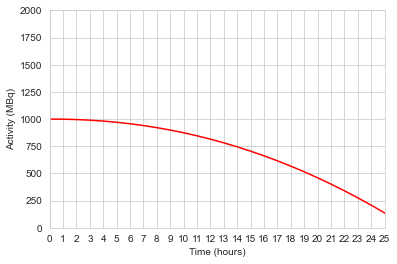

In [28]:
peakBq = 80
x = [0, 5, 10, 15, 20]
y = [1000, 800, 125, 250, 500, 1000]

def ffff(x, m, t, b):
    return b + m * x ** t


x = np.arange(101)
sns.set_style("whitegrid")
f, ax = plt.subplots()
ax.plot(x, ffff(x, -1, 2.1, 1000), 'r')
ax.set_xticks(np.linspace(0, 25, 26))
ax.set_xlim([0,25])
ax.set_ylim([0,2000])
#ax.set_yticks(np.linspace(0, peakBq, 9))
ax.set_ylabel('Activity (MBq)')
ax.set_xlabel('Time (hours)')

-40.0 1000.0


Text(0.5, 0, 'Time (hours)')

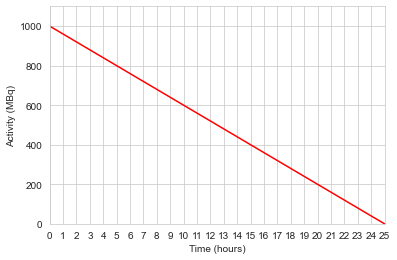

In [22]:
peakBq = 80
x = [0, 5, 10, 15, 20]
y = [1000, 800, 600, 400, 200]

def ffff(x, m, b):
    return b + m * x
params, cv = scop.curve_fit(ffff, x, y, (1000, -40))
m, b = params
print(m, b)


x = np.arange(101)
sns.set_style("whitegrid")
f, ax = plt.subplots()
ax.plot(x, ffff(x, m, b), 'r')
ax.set_xticks(np.linspace(0, 25, 26))
ax.set_xlim([0,25])
ax.set_ylim([0,1100])
#ax.set_yticks(np.linspace(0, peakBq, 9))
ax.set_ylabel('Activity (MBq)')
ax.set_xlabel('Time (hours)')